In [24]:
import pandas as pd
import re
import tempun
import matplotlib.pyplot as plt

In [2]:
cc_raw = pd.read_csv('../data/large_data/latin_raw.csv')

In [3]:
cc_raw["word_count"] = cc_raw["text"].apply(lambda x: len(x.split()))

In [28]:
cc_raw["word_count"].sum()

470180378

In [4]:
cc_raw.shape

(7819, 6)

In [5]:
cc_raw.drop("text", axis=1, inplace=True)

In [6]:
cc_raw.head(5)

,Unnamed: 0,title,author,year,word_count
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340
1,latin_xmls\100.xml,De trinitate,Novatianus,fl. 260,44792
2,latin_xmls\10000.xml,De quadratura circuli,Franco Leodiensis,NaN,1648
3,latin_xmls\10001.xml,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518
4,latin_xmls\10002.xml,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532


In [7]:
# TO-DO
cc_raw["year"].apply(lambda x: "post" in str(x)).sum()

3

In [8]:
d = "fl. 1236"
def get_dates(d):
    date_dict = {}
    try:
        dates = [int(el) for el in re.findall("\d{3,4}", d)]
    except:
        dates = []
    if len(dates)==1:
        dates = [dates[0], dates[0]]
    if len(dates)==2:
        date_dict = {"not_before" : dates[0], "not_after" : dates[1]}
    else:
        date_dict = {"not_before" : None, "not_after" : None}
    return date_dict   

In [9]:
cc_raw["dates_dict"] = cc_raw["year"].apply(get_dates)
cc_raw["not_before"] =  cc_raw["dates_dict"].apply(lambda x: x["not_before"])
cc_raw["not_after"] =  cc_raw["dates_dict"].apply(lambda x: x["not_after"])
cc_raw.drop(["dates_dict"], axis=1, inplace=True)

In [10]:
cc_raw.head()

,Unnamed: 0,title,author,year,word_count,not_before,not_after
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0
1,latin_xmls\100.xml,De trinitate,Novatianus,fl. 260,44792,260.0,260.0
2,latin_xmls\10000.xml,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN
3,latin_xmls\10001.xml,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN
4,latin_xmls\10002.xml,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0


In [11]:
cc_raw["is_earlymodern"] = ((cc_raw["not_after"]>=1501)
 & (cc_raw["not_before"]<=1800))

In [26]:
cc_raw["is_earlymodern"].sum()

706

In [13]:
cc_raw[cc_raw["is_earlymodern"]]["word_count"].sum()

62657750

In [16]:
"; ".join(list(cc_raw[cc_raw["is_earlymodern"]]["author"].unique()))

"Thomas Morus; Cartesius, Renatus; Desiderius Erasmus; Maurolycus, Franciscus; Kircher, Athanasius; Eberhard Schleusinger; Vesalius, Andreas; Leibniz, Gottfried Wilhelm; Copernicus, Nicolaus; Lavater, Ludwig; Cardanus, Hieronymus; Cantemir, Demetrius; Franciscus Suarez; Bene, Franz von; Benedictus Spinoza; Giambattista della Porta; Francis Bacon; Galilei, Galileo; Johannes Kepler; Kepler, Iohannes; Giordano Bruno; Gianni Battista Cantalicio; Baldassarre Castiglione; Giacomo Leopardi; Giambattista Giraldi Cinzio; Antonio Maria Conti; Gianfrancesco Pico della Mirandola; Uberto Foglietta; Lilio Gregorio Giraldi; Sannazaro, Iacopo; Ugolino Verino; Ugo Foscolo; Ludovico Ariosto; Torquato Tasso; Ludovico Carbone; Anonymus ; Andronicus, Parthenius Tranquillus; Cunichius, Raymondus; Leuakouicz, Raphael; Marulus Spalatensis, Marcus; Gradius, Stephanus; Verantius, Michael; Skerletz, Nicolaus; Pridojevich, Iohannes; Cibel, Valentin; Eborensis, Iacobus Flavius; Ritter, Paulus; Verhovac, Maximilian

In [17]:
cc_raw["random_dates"] = cc_raw.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

[[<matplotlib.patches.Polygon at 0x15029d3f0>],

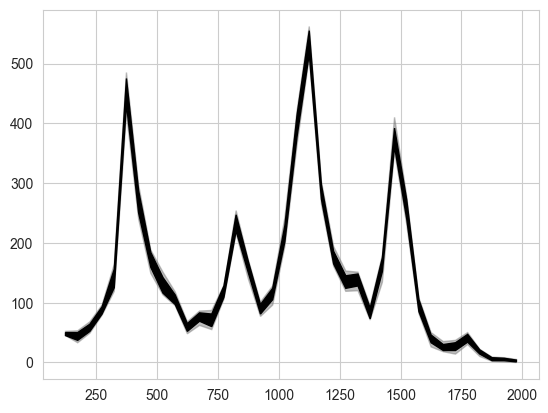

In [18]:
tempun.timeblocksplot_from_randoms(cc_raw["random_dates"])

In [20]:
def wordcount(timeblock_df, column="word_count"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].sum()
wordcounts_data = tempun.sim_data_by_function(cc_raw, 100, [-200, 1900, 50], wordcount)

In [21]:
wordcounts_data[0]

[((-200, -151), 0),
 ((-150, -101), 0),
 ((-100, -51), 0),
 ((-50, -1), 0),
 ((1, 50), 0),
 ((51, 100), 412279),
 ((101, 150), 6849327),
 ((151, 200), 2430301),
 ((201, 250), 1457530),
 ((251, 300), 4241474),
 ((301, 350), 11042792),
 ((351, 400), 42989439),
 ((401, 450), 21565734),
 ((451, 500), 7593676),
 ((501, 550), 13700404),
 ((551, 600), 8256990),
 ((601, 650), 3732813),
 ((651, 700), 3699964),
 ((701, 750), 4462487),
 ((751, 800), 6310679),
 ((801, 850), 14170071),
 ((851, 900), 12162086),
 ((901, 950), 3225125),
 ((951, 1000), 3083665),
 ((1001, 1050), 6591072),
 ((1051, 1100), 20704373),
 ((1101, 1150), 42226565),
 ((1151, 1200), 22108775),
 ((1201, 1250), 28424079),
 ((1251, 1300), 23317581),
 ((1301, 1350), 15111535),
 ((1351, 1400), 2216390),
 ((1401, 1450), 3536025),
 ((1451, 1500), 6901635),
 ((1501, 1550), 8681469),
 ((1551, 1600), 19195279),
 ((1601, 1650), 21090545),
 ((1651, 1700), 3420834),
 ((1701, 1750), 2837063),
 ((1751, 1800), 2300268),
 ((1801, 1850), 378890),

[Text(0, 10000000, '10M'),
 Text(0, 20000000, '20M'),
 Text(0, 30000000, '30M'),
 Text(0, 40000000, '40M'),
 Text(0, 50000000, '50M')]

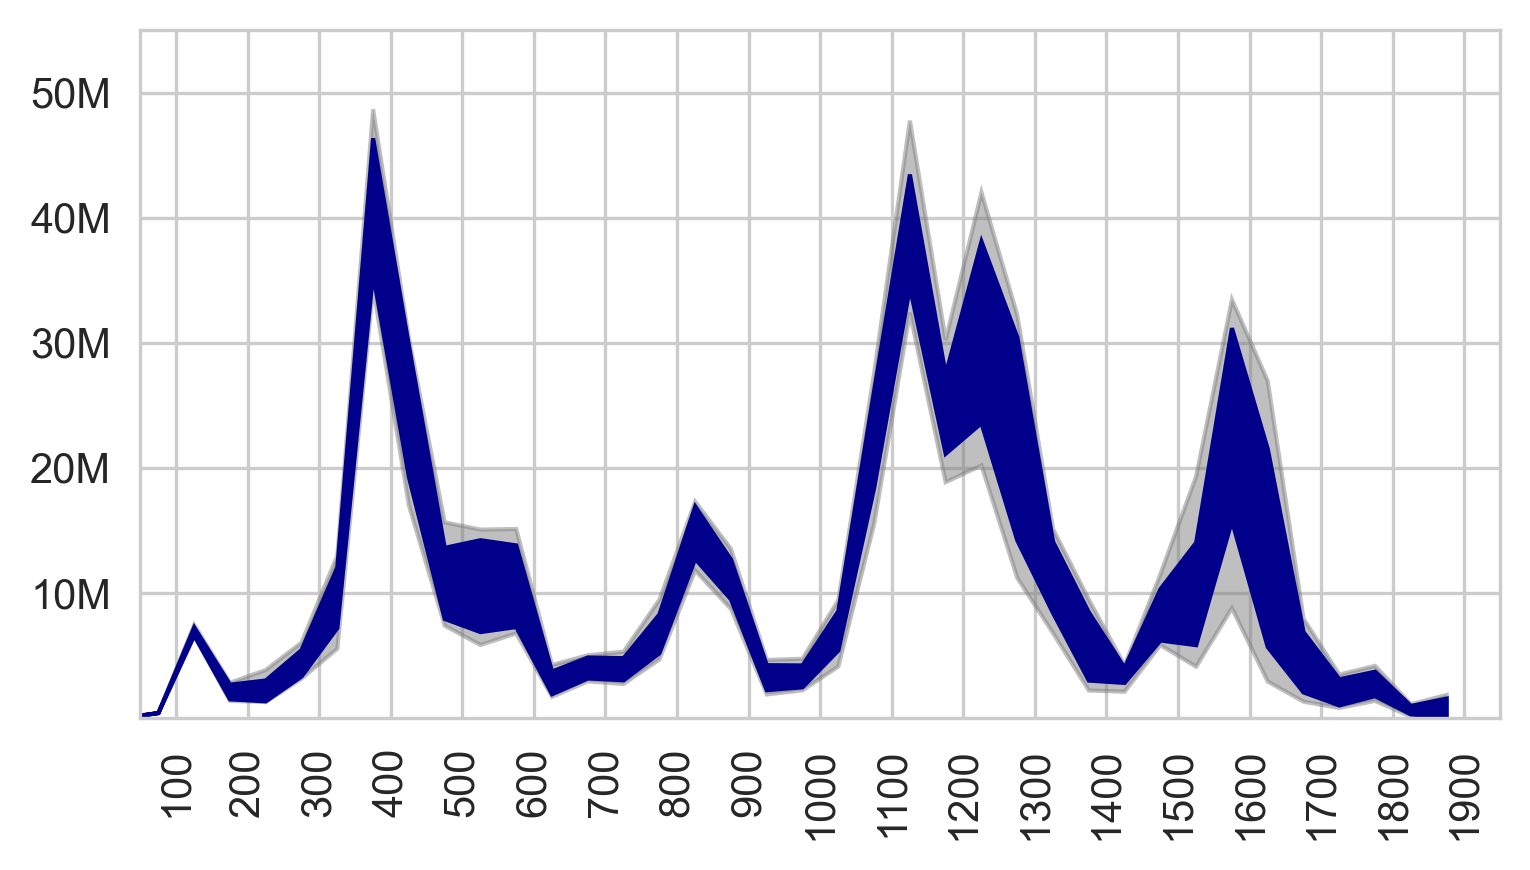

In [37]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
tempun.plot_timeblocks_data(wordcounts_data, ax=ax, color="darkblue")
ax.set_xticks(range(100,2000,100))
ax.set_xticklabels([str(el) for el in range(100,2000,100)], rotation=90)
ax.set_xlim(50, 1950)

ax.set_ylim(0,55000000)
ax.set_yticks(range(10000000, 60000000, 10000000))
ax.set_yticklabels([str(el) + "M" for el in range(10, 60, 10)])


In [38]:
fig.savefig("../figures/corpus-corporum_tempdist.png")